In [2]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=35

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [5]:
class_name=dataset.class_names

In [6]:
# plt.figure(figsize=(10,10))
# for image_batch,label_batch in dataset.take(1):
#     for i in range(12):
#         ax=plt.subplot(3,4,i+1)
#         plt.imshow(image_batch[0].numpy().astype("uint8"))
#         plt.title(class_name[label_batch[i]])
#         plt.axis("off")

In [7]:
def get_dataset_partition(df,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(df)

    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_data=df.take(train_size)
    val_data=df.skip(train_size).take(val_size)
    test_data=df.skip(train_size).skip(val_size)

    return train_data,val_data,test_data
    

In [8]:
train_data,val_data,test_data=get_dataset_partition(dataset)

In [9]:
train_data=train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255.0),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [12]:
INPUT_SHAPE=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=INPUT_SHAPE),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,(3,3),activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64,(3,3),activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=INPUT_SHAPE)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [15]:
history=model.fit(
    train_data,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data
)

Epoch 1/35


54/54 [==============================] - 70s 1s/step - loss: 0.7187 - accuracy: 0.6910 - val_loss: 0.5686 - val_accuracy: 0.8177
Epoch 2/35
54/54 [==============================] - 64s 1s/step - loss: 0.3508 - accuracy: 0.8646 - val_loss: 0.2277 - val_accuracy: 0.8906
Epoch 3/35
54/54 [==============================] - 77s 1s/step - loss: 0.2138 - accuracy: 0.9149 - val_loss: 0.1471 - val_accuracy: 0.9479
Epoch 4/35
54/54 [==============================] - 82s 2s/step - loss: 0.1923 - accuracy: 0.9242 - val_loss: 0.2330 - val_accuracy: 0.9010
Epoch 5/35
54/54 [==============================] - 91s 2s/step - loss: 0.1302 - accuracy: 0.9520 - val_loss: 0.1317 - val_accuracy: 0.9740
Epoch 6/35
54/54 [==============================] - 96s 2s/step - loss: 0.1380 - accuracy: 0.9473 - val_loss: 0.1524 - val_accuracy: 0.9531
Epoch 7/35
54/54 [==============================] - 89s 2s/step - loss: 0.1168 - accuracy: 0.9543 - val_loss: 0.1157 - val_accuracy: 0.9740
Epoch 8/35
54/54 [=============

In [16]:
scores = model.evaluate(test_data)

8/8 [==============================] - 3s 294ms/step - loss: 0.2652 - accuracy: 0.9062


In [17]:
scores

[0.2651779353618622, 0.90625]

In [18]:
history

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

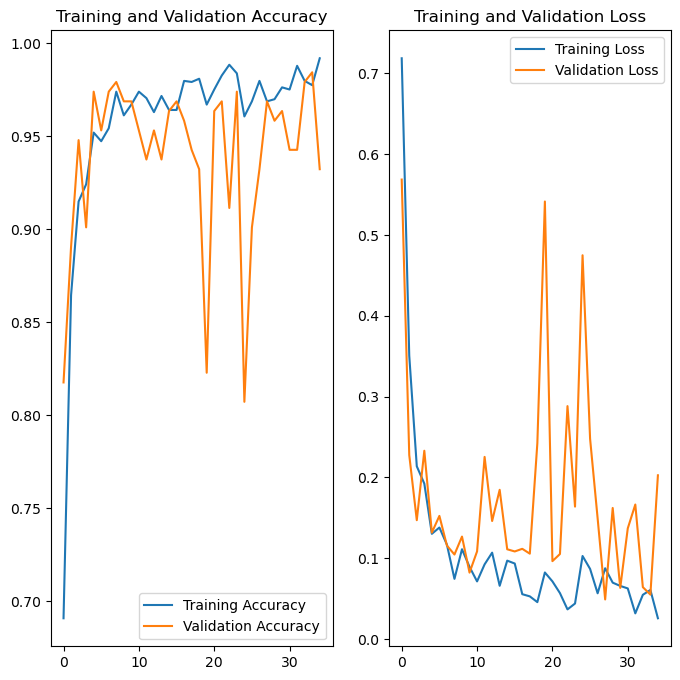

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 376ms/step
predicted label: Potato___Early_blight


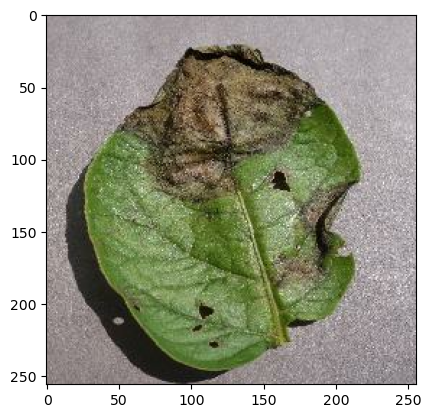

In [21]:

import numpy as np
for images_batch, labels_batch in test_data.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])


In [27]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


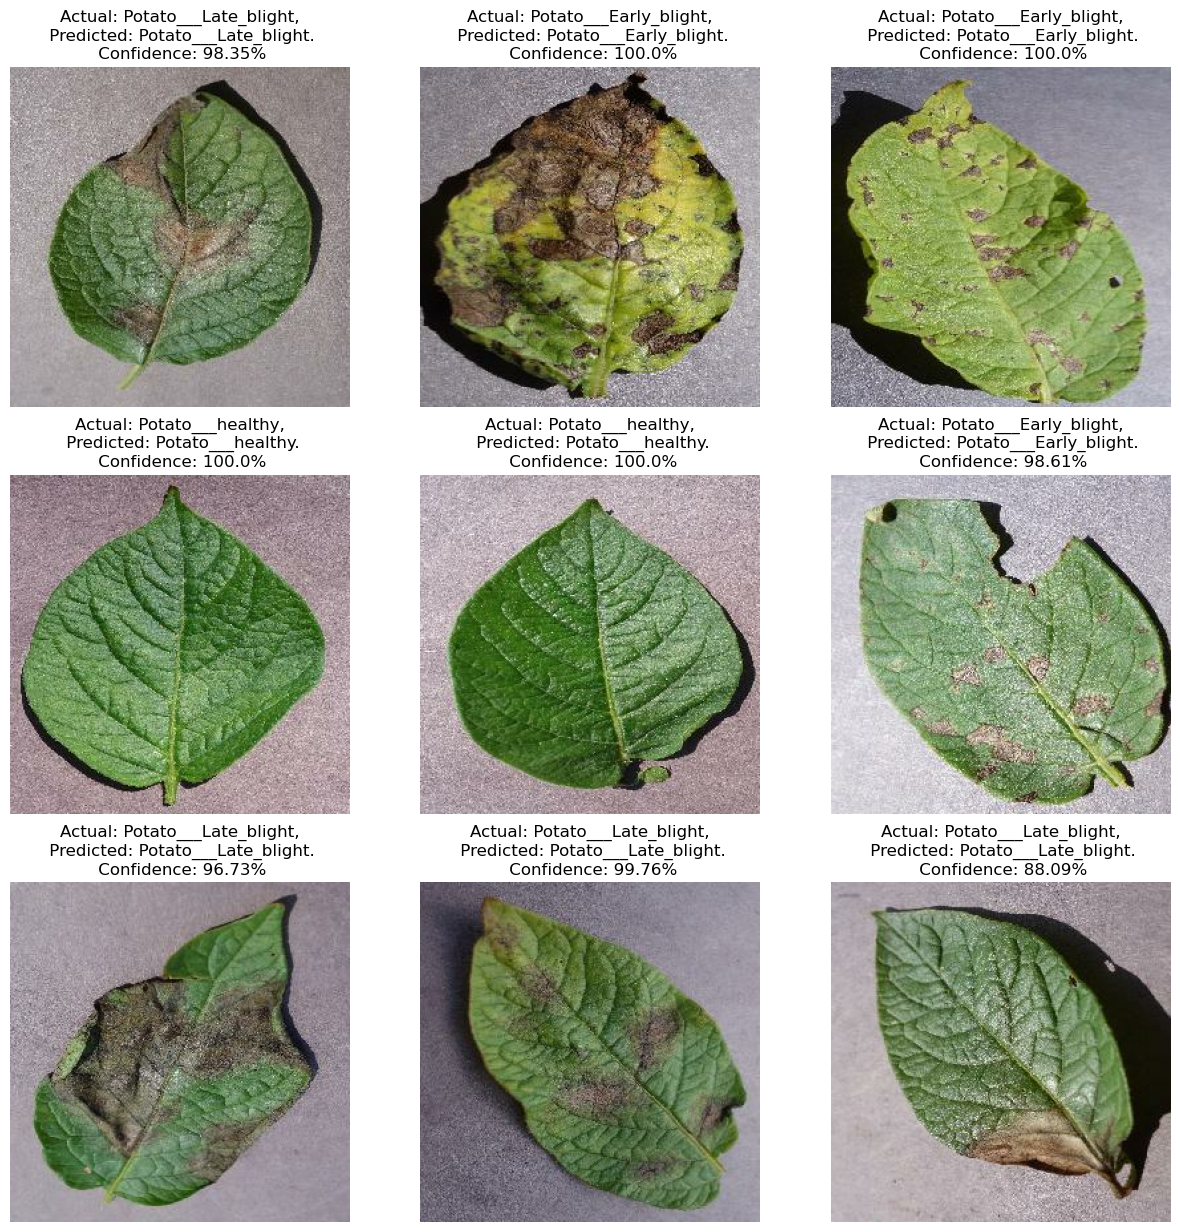

In [28]:
plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [30]:
# import os

# model_dir = "../models"

# # Check if the directory exists, and create it if it doesn't
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# # List the existing model versions
# model_versions = [int(i) for i in os.listdir(model_dir)]

# # If there are no existing versions, start with version 0
# if not model_versions:
#     model_version = 0
# else:
#     model_version = max(model_versions) + 1

# model.save(f"{model_dir}/{model_version}")

import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")



INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [ ]:
model.save("../potatoes.h5")